## Задача: Отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска..

### Этапы работы:
1. Импорт библиотек и данных
2. Первичный осмотр и анализ данных в целом
(переименование столбцов, удаление столбцов не имеющих ценности,
анализ содежания отсутствующих данных, поиск дубликатов)
3. Анализ и обработка числовых данных
(нахождение статистических значений, удаление выбросов,
построение гистограммы распределения, обработка пустых значений)
4. Анализ и обработка номинативных признаков
(нахождение статистических значений, обработка пустых значений,
построение boxplot)
5. Обогащение данных
(формирование дополнительных столбцов)
6. Кореляционный анализ числовых данных
7. Анализ номинативных данных
8. Выводы

### Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from itertools import combinations
from scipy.stats import ttest_ind

### Импорт данных

In [2]:
stud_data = pd.read_csv('./data/stud_math.csv')

### Настройка отображения

In [3]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

### Функции

In [4]:
def numerical_value_data(column_name, allowed_values):
    '''Получение статистических значений для числовых столбцов'''

    perc25 = stud_data[column_name].quantile(0.25)
    perc75 = stud_data[column_name].quantile(0.75)

    print('Количество элементов: {}'.format(stud_data[column_name].size))
    print('Количество непустых элементов: {}'.format(
        stud_data[column_name].count()))
    print('Количество NaN элементов: {}'.format(
        stud_data[column_name].isnull().sum()))
    print('Количество элементов равных 0: {}'.format(
        stud_data[stud_data[column_name] == 0][column_name].size))
    print('')
    print('Стандартное отклонение: {}'.format(stud_data[column_name].std()))
    print('Среднее значение: {}'.format(stud_data[column_name].mean()))
    print('Медиана: {}'.format(stud_data[column_name].median()))
    print('')
    print('Квартили и выбросы:')
    print('Максимум: {}'.format(stud_data[column_name].max()))
    print('75-й квартиль: {},'.format(perc75))
    print('50-й квартиль: {},'.format(stud_data[column_name].quantile(0.5)))
    print('25-й квартиль: {},'.format(perc25))
    print('Минимум: {}'.format(stud_data[column_name].min()))
    print('IQR: {}, '.format(perc75 - perc25))
    print('Границы выбросов: [{f}, {l}].'.format(
        f=perc25 - 1.5*(perc75 - perc25), l=perc75 + 1.5*(perc75 - perc25)))
    print('')
    print('Список уникальных элементов, стобца: {}'.format(
        stud_data[column_name].unique()))
    print('Допустимые значения: {}'.format(allowed_values))


def numerical_value_hist(column_name, bins_number):
    stud_data[column_name].hist(bins=bins_number)


def numerical_value_iqr_hist(column_name, bins_number):
    perc25 = stud_data[column_name].quantile(0.25)
    perc75 = stud_data[column_name].quantile(0.75)
    IQR = perc75 - perc25
    left_border = perc25 - 1.5*IQR
    right_boredr = perc75 + 1.5*IQR

    print('Данные по выбросам:')
    print('25-й квартиль: {},'.format(perc25))
    print('75-й перцентиль: {},'.format(perc75))
    print('IQR: {}, '.format(IQR))
    print('Границы выбросов: [{f}, {l}].'.format(
        f=left_border, l=right_boredr))

    stud_data[column_name].loc[stud_data[column_name].between(
        left_border,
        right_boredr)
    ].hist(bins=bins_number, label='IQR')

    plt.legend()


score_mean_GP = int(
    round(stud_data[stud_data['school'] == 'GP']['score'].mean()))
score_mean_MS = int(
    round(stud_data[stud_data['school'] == 'MS']['score'].mean()))


def fill_score(row):
    if pd.isnull(row['score']):
        if row['school'] == 'GP':
            return round(score_mean_GP)
        return round(score_mean_MS)
    return row['score']


def nominal_value_data(column_name, allowed_values):
    print('Количество элементов: {}'.format(stud_data[column_name].size))
    print('Количество непустых элементов: {}'.format(
        stud_data[column_name].count()))
    print('Количество пустых элементов: {}'.format(
        stud_data[column_name].isnull().sum()))
    print('')
    print('Список уникальных элементов, стобца: {}'.format(
        stud_data[column_name].unique()))
    print('Допустимые значения: {}'.format(allowed_values))
    print('')
    print(stud_data[column_name].value_counts())
    print('')

    # stud_data[column_name].fillna('no data', inplace = True)
    stud_data[column_name].fillna(method='ffill', inplace=True)

    fig, ax = plt.subplots(figsize=(2, 3))
    sns.boxplot(x=column_name, y='score',
                data=stud_data.loc[stud_data.loc[:, column_name].isin(
                    stud_data.loc[:, column_name].value_counts().index[:])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column_name)
    plt.show()


def get_stat_dif(column_name):
    cols = stud_data.loc[:, column_name].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))

    for comb in combinations_all:
        if ttest_ind(stud_data.loc[stud_data.loc[:, column_name] == comb[0], 'score'],
                     stud_data.loc[stud_data.loc[:, column_name] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column_name)
            break


def guardian_edu(row):
    if row['guardian'] == 'father':
        return row['father_edu']
    else:
        return row['mother_edu']


def guardian_job(row):
    if row['guardian'] == 'father':
        return row['father_job']
    else:
        return row['mother_job']

### Первичный осмотр данных

In [5]:
stud_data.head(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0


In [6]:
# Для удобства переименуем столбцы
stud_data.columns = [
    'school', 'sex', 'age', 'address', 'family_size', 'parent_status', 'mother_edu',
    'father_edu', 'mother_job', 'father_job', 'reason', 'guardian', 'traveltime',
    'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities',
    'nursery', 'studytime_granular', 'higher', 'internet', 'romantic',
    'family_rel', 'freetime', 'goout', 'health', 'absences', 'score'
]

# Присутствует непонятная колонка "studytime_granular",
# она полностью коррелируется со столбцом "studytime"
stud_data.drop(['studytime_granular'], inplace = True, axis = 1)

In [7]:
stud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   school         395 non-null    object 
 1   sex            395 non-null    object 
 2   age            395 non-null    int64  
 3   address        378 non-null    object 
 4   family_size    368 non-null    object 
 5   parent_status  350 non-null    object 
 6   mother_edu     392 non-null    float64
 7   father_edu     371 non-null    float64
 8   mother_job     376 non-null    object 
 9   father_job     359 non-null    object 
 10  reason         378 non-null    object 
 11  guardian       364 non-null    object 
 12  traveltime     367 non-null    float64
 13  studytime      388 non-null    float64
 14  failures       373 non-null    float64
 15  schoolsup      386 non-null    object 
 16  famsup         356 non-null    object 
 17  paid           355 non-null    object 
 18  activities

#### В данных представлено 29 признаков, из них 12 числовых и 17 нечисловых признаков <br/>

###### Числовые признаки:

In [8]:
number_column_list = [
    'age', 'mother_edu',
    'father_edu', 'traveltime',
    'studytime', 'failures',
    'family_rel', 'freetime',
    'goout', 'health',
    'absences', 'score'
]

###### Номинальные признаки

In [9]:
nominal_column_list = [
    'school', 'sex',
    'address', 'family_size',
    'parent_status', 'mother_job',
    'father_job', 'reason',
    'guardian', 'schoolsup',
    'famsup', 'paid',
    'activities', 'nursery',
    'higher', 'internet',
    'romantic'
]

### Процент отсутствующих данных

In [10]:
for col in stud_data.columns:
    pct_missing = np.mean(stud_data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

school - 0.0%
sex - 0.0%
age - 0.0%
address - 4.0%
family_size - 7.0%
parent_status - 11.0%
mother_edu - 1.0%
father_edu - 6.0%
mother_job - 5.0%
father_job - 9.0%
reason - 4.0%
guardian - 8.0%
traveltime - 7.0%
studytime - 2.0%
failures - 6.0%
schoolsup - 2.0%
famsup - 10.0%
paid - 10.0%
activities - 4.0%
nursery - 4.0%
higher - 5.0%
internet - 9.0%
romantic - 8.0%
family_rel - 7.0%
freetime - 3.0%
goout - 2.0%
health - 4.0%
absences - 3.0%
score - 2.0%


In [11]:
duplicat = stud_data.duplicated()
duplicat.unique()

# Дубликаты данных отсутствуют

array([False])

## Анализ и обработка числовых признаков

### Age - возраст

Количество элементов: 395
Количество непустых элементов: 395
Количество NaN элементов: 0
Количество элементов равных 0: 0

Стандартное отклонение: 1.2760427246056245
Среднее значение: 16.696202531645568
Медиана: 17.0

Квартили и выбросы:
Максимум: 22
75-й квартиль: 18.0,
50-й квартиль: 17.0,
25-й квартиль: 16.0,
Минимум: 15
IQR: 2.0, 
Границы выбросов: [13.0, 21.0].

Список уникальных элементов, стобца: [18 17 15 16 19 22 20 21]
Допустимые значения: от 15 до 22


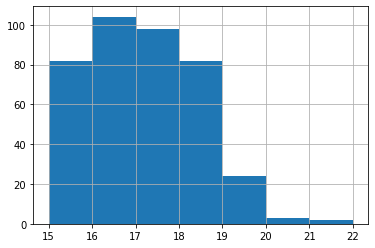

In [12]:
numerical_value_data('age', 'от 15 до 22')
numerical_value_hist('age', 7)

### Mother_Edu - образование матери

Количество элементов: 395
Количество непустых элементов: 392
Количество NaN элементов: 3
Количество элементов равных 0: 3

Стандартное отклонение: 1.0981267472114393
Среднее значение: 2.75
Медиана: 3.0

Квартили и выбросы:
Максимум: 4.0
75-й квартиль: 4.0,
50-й квартиль: 3.0,
25-й квартиль: 2.0,
Минимум: 0.0
IQR: 2.0, 
Границы выбросов: [-1.0, 7.0].

Список уникальных элементов, стобца: [ 4.  1.  3.  2. nan  0.]
Допустимые значения: 0, 1, 2, 3, 4


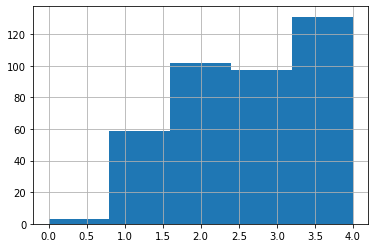

In [13]:
numerical_value_data('mother_edu', '0, 1, 2, 3, 4')
numerical_value_hist('mother_edu', 5)

Данные по выбросам:
25-й квартиль: 2.0,
75-й перцентиль: 4.0,
IQR: 2.0, 
Границы выбросов: [-1.0, 7.0].


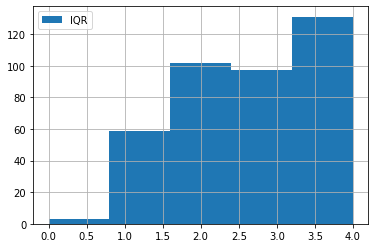

In [14]:
numerical_value_iqr_hist('mother_edu', 5)

In [15]:
# Выбросы отсутствуют
# Есть пустые значения

# Заменяем все пустые значения на медиану
stud_data['mother_edu'].fillna(3.0, inplace = True)

### Father_Edu - образование отца

Количество элементов: 395
Количество непустых элементов: 371
Количество NaN элементов: 24
Количество элементов равных 0: 2

Стандартное отклонение: 2.228732157841757
Среднее значение: 2.61455525606469
Медиана: 2.0

Квартили и выбросы:
Максимум: 40.0
75-й квартиль: 3.0,
50-й квартиль: 2.0,
25-й квартиль: 2.0,
Минимум: 0.0
IQR: 1.0, 
Границы выбросов: [0.5, 4.5].

Список уникальных элементов, стобца: [ 4.  1.  2.  3. 40. nan  0.]
Допустимые значения: 0, 1, 2, 3, 4


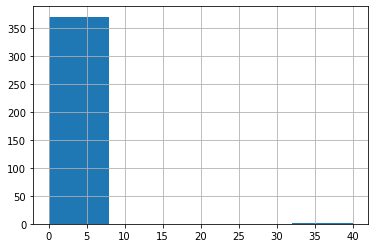

In [16]:
numerical_value_data('father_edu', '0, 1, 2, 3, 4')
numerical_value_hist('father_edu', 5)

Данные по выбросам:
25-й квартиль: 2.0,
75-й перцентиль: 3.0,
IQR: 1.0, 
Границы выбросов: [0.5, 4.5].


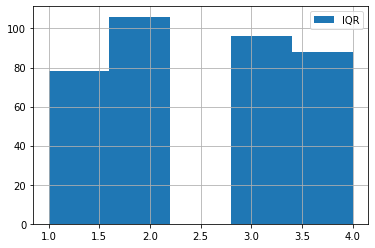

In [17]:
numerical_value_iqr_hist('father_edu', 5)

In [18]:
# Присутствуют выбросы
# Есть пустые значения

# Заменяем все пустые значения выбросы на медиану
stud_data['father_edu'].fillna(2.0, inplace = True)
stud_data['father_edu'] = stud_data.father_edu.apply(lambda x: x if x < 4.5 else 2.0)

### Traveltime - время в пути до школы

Количество элементов: 395
Количество непустых элементов: 367
Количество NaN элементов: 28
Количество элементов равных 0: 0

Стандартное отклонение: 0.6941806748311099
Среднее значение: 1.438692098092643
Медиана: 1.0

Квартили и выбросы:
Максимум: 4.0
75-й квартиль: 2.0,
50-й квартиль: 1.0,
25-й квартиль: 1.0,
Минимум: 1.0
IQR: 1.0, 
Границы выбросов: [-0.5, 3.5].

Список уникальных элементов, стобца: [ 2.  1.  3. nan  4.]
Допустимые значения: 1, 2, 3, 4


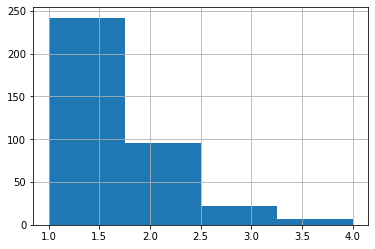

In [19]:
numerical_value_data('traveltime', '1, 2, 3, 4')
numerical_value_hist('traveltime', 4)

Данные по выбросам:
25-й квартиль: 1.0,
75-й перцентиль: 2.0,
IQR: 1.0, 
Границы выбросов: [-0.5, 3.5].


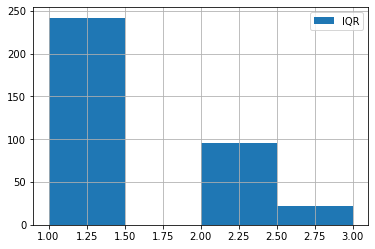

In [20]:
numerical_value_iqr_hist('traveltime', 4)

In [21]:
# Выбросы отсутствуют
# Есть пустые значения

# Заменяем все пустые значения на медиану
stud_data['traveltime'].fillna(1.0, inplace = True)

### Studytime - время на учёбу помимо школы в неделю

Количество элементов: 395
Количество непустых элементов: 388
Количество NaN элементов: 7
Количество элементов равных 0: 0

Стандартное отклонение: 0.8420783061121849
Среднее значение: 2.038659793814433
Медиана: 2.0

Квартили и выбросы:
Максимум: 4.0
75-й квартиль: 2.0,
50-й квартиль: 2.0,
25-й квартиль: 1.0,
Минимум: 1.0
IQR: 1.0, 
Границы выбросов: [-0.5, 3.5].

Список уникальных элементов, стобца: [ 2.  3.  1. nan  4.]
Допустимые значения: 1, 2, 3, 4


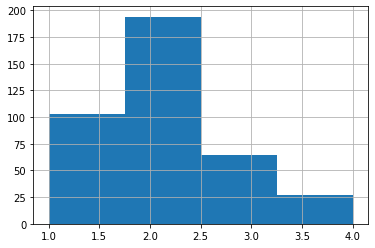

In [22]:
numerical_value_data('studytime', '1, 2, 3, 4')
numerical_value_hist('studytime', 4)

Данные по выбросам:
25-й квартиль: 1.0,
75-й перцентиль: 2.0,
IQR: 1.0, 
Границы выбросов: [-0.5, 3.5].


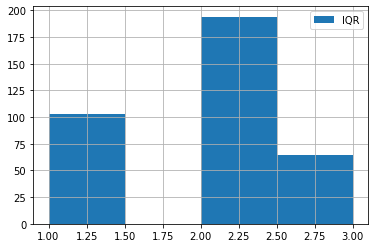

In [23]:
numerical_value_iqr_hist('studytime', 4)

In [24]:
# Выбросы отсутствуют
# Есть пустые значения

# Заменяем все пустые значения на медиану
stud_data['studytime'].fillna(2.0, inplace = True)

### Failures - количество внеучебных неудач

Количество элементов: 395
Количество непустых элементов: 373
Количество NaN элементов: 22
Количество элементов равных 0: 293

Стандартное отклонение: 0.7431352452905915
Среднее значение: 0.3378016085790885
Медиана: 0.0

Квартили и выбросы:
Максимум: 3.0
75-й квартиль: 0.0,
50-й квартиль: 0.0,
25-й квартиль: 0.0,
Минимум: 0.0
IQR: 0.0, 
Границы выбросов: [0.0, 0.0].

Список уникальных элементов, стобца: [ 0.  3. nan  2.  1.]
Допустимые значения: 0, 1, 2, 3


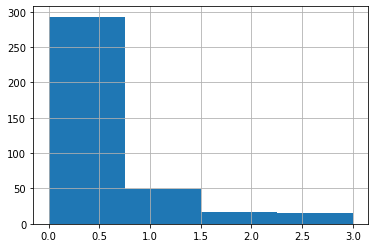

In [25]:
numerical_value_data('failures', '0, 1, 2, 3')
numerical_value_hist('failures', 4)

Данные по выбросам:
25-й квартиль: 0.0,
75-й перцентиль: 0.0,
IQR: 0.0, 
Границы выбросов: [0.0, 0.0].


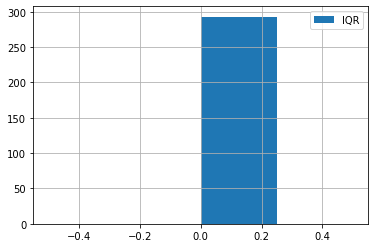

In [26]:
numerical_value_iqr_hist('failures', 4)

In [27]:
# Выбросы отсутствуют
# Есть пустые значения

# Заменяем все пустые значения на медиану
stud_data['failures'].fillna(0, inplace = True)

### Family_rel - отношения в семье

Количество элементов: 395
Количество непустых элементов: 368
Количество NaN элементов: 27
Количество элементов равных 0: 0

Стандартное отклонение: 0.9272773717991188
Среднее значение: 3.9375
Медиана: 4.0

Квартили и выбросы:
Максимум: 5.0
75-й квартиль: 5.0,
50-й квартиль: 4.0,
25-й квартиль: 4.0,
Минимум: -1.0
IQR: 1.0, 
Границы выбросов: [2.5, 6.5].

Список уникальных элементов, стобца: [ 4.  5.  3. nan -1.  2.  1.]
Допустимые значения: от 1 до 5


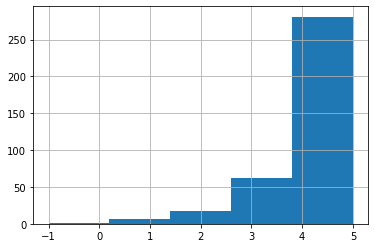

In [28]:
numerical_value_data('family_rel', 'от 1 до 5')
numerical_value_hist('family_rel', 5)

Данные по выбросам:
25-й квартиль: 4.0,
75-й перцентиль: 5.0,
IQR: 1.0, 
Границы выбросов: [2.5, 6.5].


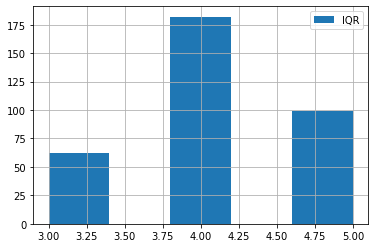

In [29]:
numerical_value_iqr_hist('family_rel', 5)

In [30]:
# Присутствуют выбросы
# Есть пустые значения

# Заменяем все пустые значения выбросы на медиану
stud_data['family_rel'].fillna(4.0, inplace = True)
stud_data['family_rel'] = stud_data.family_rel.apply(lambda x: x if x < 1.0 else 4.0)

### Freetime  - свободное время после школы

Количество элементов: 395
Количество непустых элементов: 384
Количество NaN элементов: 11
Количество элементов равных 0: 0

Стандартное отклонение: 0.9939403818104774
Среднее значение: 3.2317708333333335
Медиана: 3.0

Квартили и выбросы:
Максимум: 5.0
75-й квартиль: 4.0,
50-й квартиль: 3.0,
25-й квартиль: 3.0,
Минимум: 1.0
IQR: 1.0, 
Границы выбросов: [1.5, 5.5].

Список уникальных элементов, стобца: [ 3.  2.  4.  1.  5. nan]
Допустимые значения: от 1 до 5


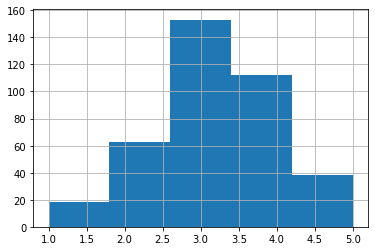

In [31]:
numerical_value_data('freetime', 'от 1 до 5')
numerical_value_hist('freetime', 5)

Данные по выбросам:
25-й квартиль: 3.0,
75-й перцентиль: 4.0,
IQR: 1.0, 
Границы выбросов: [1.5, 5.5].


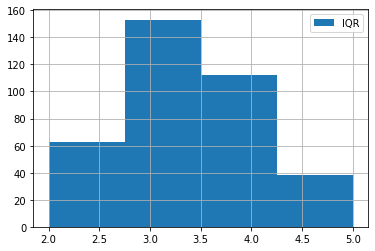

In [32]:
numerical_value_iqr_hist('freetime', 4)

In [33]:
# Выбросы отсутствуют
# Есть пустые значения

# Заменяем все пустые значения на медиану
stud_data['freetime'].fillna(3.0, inplace = True)

### Goout - проведение времени с друзьями

Количество элементов: 395
Количество непустых элементов: 387
Количество NaN элементов: 8
Количество элементов равных 0: 0

Стандартное отклонение: 1.115895897828766
Среднее значение: 3.1059431524547803
Медиана: 3.0

Квартили и выбросы:
Максимум: 5.0
75-й квартиль: 4.0,
50-й квартиль: 3.0,
25-й квартиль: 2.0,
Минимум: 1.0
IQR: 2.0, 
Границы выбросов: [-1.0, 7.0].

Список уникальных элементов, стобца: [ 4.  3.  2.  1.  5. nan]
Допустимые значения: от 1 до 5


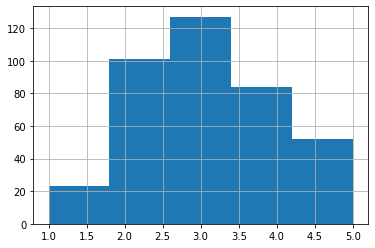

In [34]:
numerical_value_data('goout', 'от 1 до 5')
numerical_value_hist('goout', 5)

Данные по выбросам:
25-й квартиль: 2.0,
75-й перцентиль: 4.0,
IQR: 2.0, 
Границы выбросов: [-1.0, 7.0].


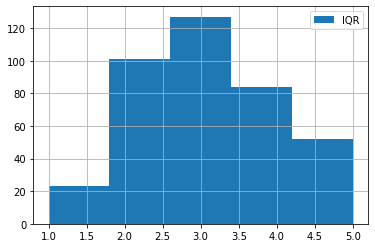

In [35]:
numerical_value_iqr_hist('goout', 5)

In [36]:
# Выбросы отсутствуют
# Есть пустые значения

# Заменяем все пустые значения на медиану
stud_data['goout'].fillna(3.0, inplace = True)

### Health - состояние здровья

Количество элементов: 395
Количество непустых элементов: 380
Количество NaN элементов: 15
Количество элементов равных 0: 0

Стандартное отклонение: 1.3960187007158011
Среднее значение: 3.531578947368421
Медиана: 4.0

Квартили и выбросы:
Максимум: 5.0
75-й квартиль: 5.0,
50-й квартиль: 4.0,
25-й квартиль: 3.0,
Минимум: 1.0
IQR: 2.0, 
Границы выбросов: [0.0, 8.0].

Список уникальных элементов, стобца: [ 3.  5.  1.  2.  4. nan]
Допустимые значения: от 1 до 5


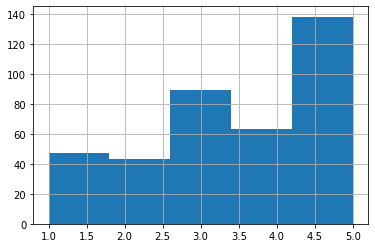

In [37]:
numerical_value_data('health', 'от 1 до 5')
numerical_value_hist('health', 5)

Данные по выбросам:
25-й квартиль: 3.0,
75-й перцентиль: 5.0,
IQR: 2.0, 
Границы выбросов: [0.0, 8.0].


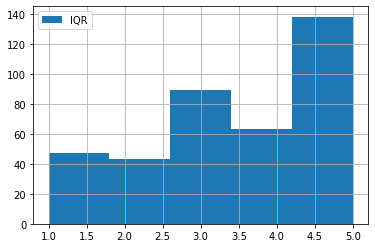

In [38]:
numerical_value_iqr_hist('health', 5)

In [39]:
# Выбросы отсутствуют
# Есть пустые значения

# Заменяем все пустые значения на медиану
stud_data['health'].fillna(4.0, inplace = True)

### Absences - количество пропущенных занятий

Количество элементов: 395
Количество непустых элементов: 383
Количество NaN элементов: 12
Количество элементов равных 0: 111

Стандартное отклонение: 23.46519685578298
Среднее значение: 7.2793733681462145
Медиана: 4.0

Квартили и выбросы:
Максимум: 385.0
75-й квартиль: 8.0,
50-й квартиль: 4.0,
25-й квартиль: 0.0,
Минимум: 0.0
IQR: 8.0, 
Границы выбросов: [-12.0, 20.0].

Список уникальных элементов, стобца: [  6.   4.  10.   2.   0.  16.  nan  14.   7.   8.  25.  12.  54.  18.
  26.  20.  56.  24.  28.   5.  13.  15.  22.   3. 385.  21.   1.  75.
  30.  19.   9.  11.  38.  40.  23.  17. 212.]
Допустимые значения: ...


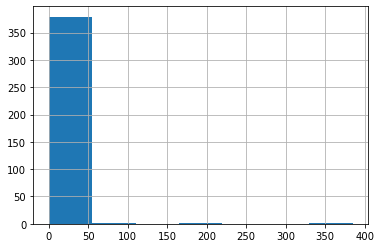

In [40]:
numerical_value_data('absences', '...')
numerical_value_hist('absences', 7)

Данные по выбросам:
25-й квартиль: 0.0,
75-й перцентиль: 8.0,
IQR: 8.0, 
Границы выбросов: [-12.0, 20.0].


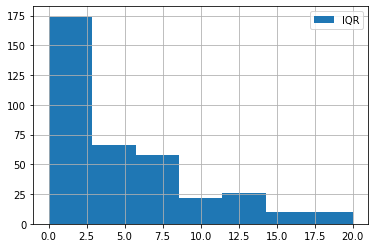

In [41]:
numerical_value_iqr_hist('absences', 7)

In [42]:
# Присутствуют выбросы
# Есть пустые значения

# Заменяем все пустые значения выбросы на медиану
stud_data['absences'].fillna(4.0, inplace = True)
stud_data['absences'] = stud_data.absences.apply(lambda x: x if (x >= 0) & (x <= 20) else 4.0)

### Score - баллы по госэкзамену по математике

Количество элементов: 395
Количество непустых элементов: 389
Количество NaN элементов: 6
Количество элементов равных 0: 37

Стандартное отклонение: 22.919022312471654
Среднее значение: 52.26221079691517
Медиана: 55.0

Квартили и выбросы:
Максимум: 100.0
75-й квартиль: 70.0,
50-й квартиль: 55.0,
25-й квартиль: 40.0,
Минимум: 0.0
IQR: 30.0, 
Границы выбросов: [-5.0, 115.0].

Список уникальных элементов, стобца: [ 30.  50.  75.  55.  95.  45.  60.  70.  80.  25.  40.  85.  90.  65.
 100.  35.   0.  nan  20.]
Допустимые значения: от 0 до 100


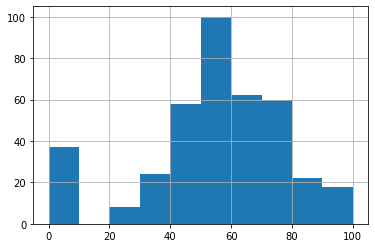

In [43]:
numerical_value_data('score', 'от 0 до 100')
numerical_value_hist('score', 10)

Данные по выбросам:
25-й квартиль: 40.0,
75-й перцентиль: 70.0,
IQR: 30.0, 
Границы выбросов: [-5.0, 115.0].


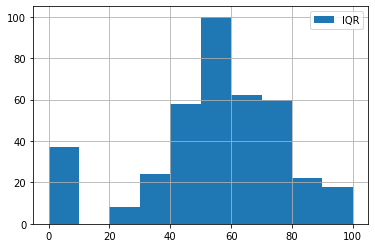

In [44]:
numerical_value_iqr_hist('score', 10)

In [45]:
# Выбросы отсутствуют
# Есть пустые значения

# Заменяем все пустые значения на медиану по каждой школе
stud_data['score'] = stud_data.apply(fill_score, axis=1)

## Анализ и обработка нечисловых признаков

### School - школа

Количество элементов: 395
Количество непустых элементов: 395
Количество пустых элементов: 0

Список уникальных элементов, стобца: ['GP' 'MS']
Допустимые значения: ...

GP    349
MS     46
Name: school, dtype: int64



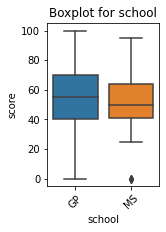

In [46]:
nominal_value_data('school', '...')
get_stat_dif('school')

### Sex - пол

Количество элементов: 395
Количество непустых элементов: 395
Количество пустых элементов: 0

Список уникальных элементов, стобца: ['F' 'M']
Допустимые значения: ...

F    208
M    187
Name: sex, dtype: int64



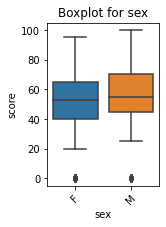

In [47]:
nominal_value_data('sex', '...')
get_stat_dif('sex')

### Address - локация

Количество элементов: 395
Количество непустых элементов: 378
Количество пустых элементов: 17

Список уникальных элементов, стобца: ['U' nan 'R']
Допустимые значения: ...

U    295
R     83
Name: address, dtype: int64



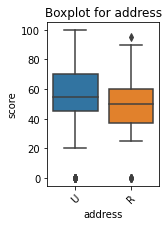

Найдены статистически значимые различия для колонки address


In [48]:
nominal_value_data('address', '...')
get_stat_dif('address')

### Family_size - размер семьи

Количество элементов: 395
Количество непустых элементов: 368
Количество пустых элементов: 27

Список уникальных элементов, стобца: [nan 'GT3' 'LE3']
Допустимые значения: ...

GT3    261
LE3    107
Name: family_size, dtype: int64



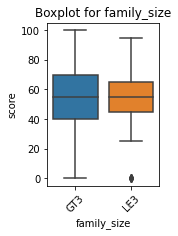

In [49]:
nominal_value_data('family_size', '...')
get_stat_dif('family_size')

### Parent_status - брачный статус родителей

Количество элементов: 395
Количество непустых элементов: 350
Количество пустых элементов: 45

Список уникальных элементов, стобца: ['A' nan 'T']
Допустимые значения: ...

T    314
A     36
Name: parent_status, dtype: int64



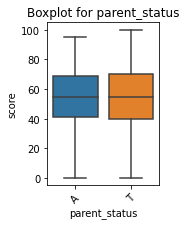

In [50]:
nominal_value_data('parent_status', '...')
get_stat_dif('parent_status')

### Mother_job - место работы матери

Количество элементов: 395
Количество непустых элементов: 376
Количество пустых элементов: 19

Список уникальных элементов, стобца: ['at_home' 'health' 'other' 'services' 'teacher' nan]
Допустимые значения: ...

other       133
services     98
at_home      58
teacher      55
health       32
Name: mother_job, dtype: int64



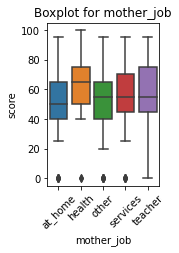

Найдены статистически значимые различия для колонки mother_job


In [51]:
nominal_value_data('mother_job', '...')
get_stat_dif('mother_job')

### Father_job - место работы отца

Количество элементов: 395
Количество непустых элементов: 359
Количество пустых элементов: 36

Список уникальных элементов, стобца: ['teacher' 'other' nan 'health' 'services' 'at_home']
Допустимые значения: ...

other       197
services    102
teacher      29
at_home      16
health       15
Name: father_job, dtype: int64



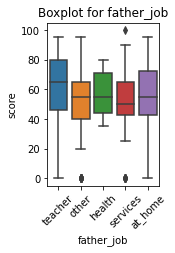

In [52]:
nominal_value_data('father_job', '...')
get_stat_dif('father_job')

### Reason - причина выбора данной школы

Количество элементов: 395
Количество непустых элементов: 378
Количество пустых элементов: 17

Список уникальных элементов, стобца: ['course' 'other' 'home' 'reputation' nan]
Допустимые значения: ...

course        137
home          104
reputation    103
other          34
Name: reason, dtype: int64



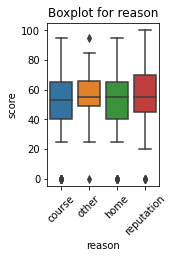

In [53]:
nominal_value_data('reason', '...')
get_stat_dif('reason')

### Guardian - опекун

Количество элементов: 395
Количество непустых элементов: 364
Количество пустых элементов: 31

Список уникальных элементов, стобца: ['mother' 'father' 'other' nan]
Допустимые значения: ...

mother    250
father     86
other      28
Name: guardian, dtype: int64



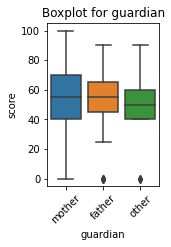

In [54]:
nominal_value_data('guardian', '...')
get_stat_dif('guardian')

### Schoolsup - дополнительная образовательная поддержка (yes или no) 

Количество элементов: 395
Количество непустых элементов: 386
Количество пустых элементов: 9

Список уникальных элементов, стобца: ['yes' 'no' nan]
Допустимые значения: ...

no     335
yes     51
Name: schoolsup, dtype: int64



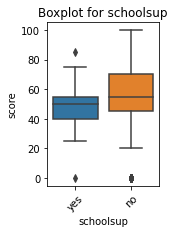

In [55]:
nominal_value_data('schoolsup', '...')
get_stat_dif('schoolsup')

### Famsup - семейная образовательная поддержка (yes или no)

Количество элементов: 395
Количество непустых элементов: 356
Количество пустых элементов: 39

Список уникальных элементов, стобца: ['no' 'yes' nan]
Допустимые значения: ...

yes    219
no     137
Name: famsup, dtype: int64



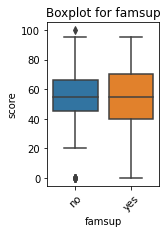

In [56]:
nominal_value_data('famsup', '...')
get_stat_dif('famsup')

### Paid - дополнительные платные занятия по математике (yes или no)

Количество элементов: 395
Количество непустых элементов: 355
Количество пустых элементов: 40

Список уникальных элементов, стобца: ['no' nan 'yes']
Допустимые значения: ...

no     200
yes    155
Name: paid, dtype: int64



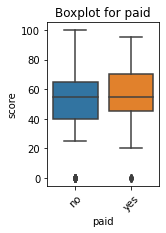

In [57]:
nominal_value_data('paid', '...')
get_stat_dif('paid')

### Activities - дополнительные внеучебные занятия (yes или no)

Количество элементов: 395
Количество непустых элементов: 381
Количество пустых элементов: 14

Список уникальных элементов, стобца: ['no' 'yes' nan]
Допустимые значения: ...

yes    195
no     186
Name: activities, dtype: int64



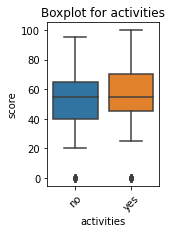

In [58]:
nominal_value_data('activities', '...')
get_stat_dif('activities')

### Nursery - посещал детский сад (yes или no)

Количество элементов: 395
Количество непустых элементов: 379
Количество пустых элементов: 16

Список уникальных элементов, стобца: ['yes' 'no' nan]
Допустимые значения: ...

yes    300
no      79
Name: nursery, dtype: int64



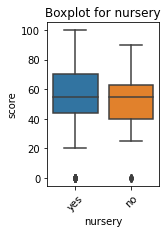

In [59]:
nominal_value_data('nursery', '...')
get_stat_dif('nursery')

### Higher - хочет получить высшее образование (yes или no)

Количество элементов: 395
Количество непустых элементов: 375
Количество пустых элементов: 20

Список уникальных элементов, стобца: ['yes' nan 'no']
Допустимые значения: ...

yes    356
no      19
Name: higher, dtype: int64



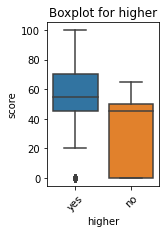

Найдены статистически значимые различия для колонки higher


In [60]:
nominal_value_data('higher', '...')
get_stat_dif('higher')

### Internet - наличие интернета дома (yes или no)

Количество элементов: 395
Количество непустых элементов: 361
Количество пустых элементов: 34

Список уникальных элементов, стобца: [nan 'yes' 'no']
Допустимые значения: ...

yes    305
no      56
Name: internet, dtype: int64



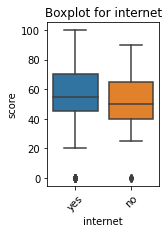

In [61]:
nominal_value_data('internet', '...')
get_stat_dif('internet')

### Romantic - в романтических отношениях (yes или no)

Количество элементов: 395
Количество непустых элементов: 364
Количество пустых элементов: 31

Список уникальных элементов, стобца: ['no' nan 'yes']
Допустимые значения: ...

no     240
yes    124
Name: romantic, dtype: int64



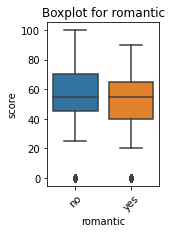

Найдены статистически значимые различия для колонки romantic


In [62]:
nominal_value_data('romantic', '...')
get_stat_dif('romantic')

## Формирование дополнительных столбцов "Образование опекуна" и "Профессия опекуна"

In [63]:
# Проверим гипотезу, что воспитанием ребенка и наибольше влияние на ребенка оказывает опекун
# Добавляем новые столбцы guardian_edu ("Образование опекуна") guardian_job ("Работа опекуна")

stud_data['guardian_edu'] = stud_data.apply(guardian_edu, axis = 1)
stud_data['guardian_job'] = stud_data.apply(guardian_job, axis = 1)

Количество элементов: 395
Количество непустых элементов: 395
Количество NaN элементов: 0
Количество элементов равных 0: 2

Стандартное отклонение: 1.070099719657435
Среднее значение: 2.7443037974683544
Медиана: 3.0

Квартили и выбросы:
Максимум: 4.0
75-й квартиль: 4.0,
50-й квартиль: 3.0,
25-й квартиль: 2.0,
Минимум: 0.0
IQR: 2.0, 
Границы выбросов: [-1.0, 7.0].

Список уникальных элементов, стобца: [4. 1. 3. 2. 0.]
Допустимые значения: ...


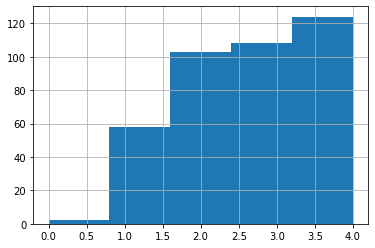

In [64]:
numerical_value_data('guardian_edu', '...')
numerical_value_hist('guardian_edu', 5)

Данные по выбросам:
25-й квартиль: 2.0,
75-й перцентиль: 4.0,
IQR: 2.0, 
Границы выбросов: [-1.0, 7.0].


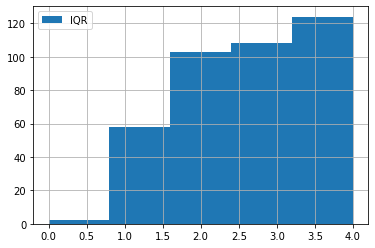

In [65]:
numerical_value_iqr_hist('guardian_edu', 5)

Количество элементов: 395
Количество непустых элементов: 395
Количество пустых элементов: 0

Список уникальных элементов, стобца: ['at_home' 'other' 'health' 'services' 'teacher']
Допустимые значения: ...

other       137
services    118
at_home      57
teacher      57
health       26
Name: guardian_job, dtype: int64



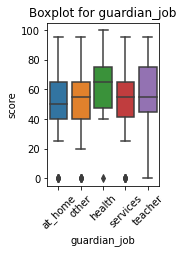

Найдены статистически значимые различия для колонки guardian_job


In [66]:
nominal_value_data('guardian_job', '...')
get_stat_dif('guardian_job')

## Корреляционный анализ числовых данных

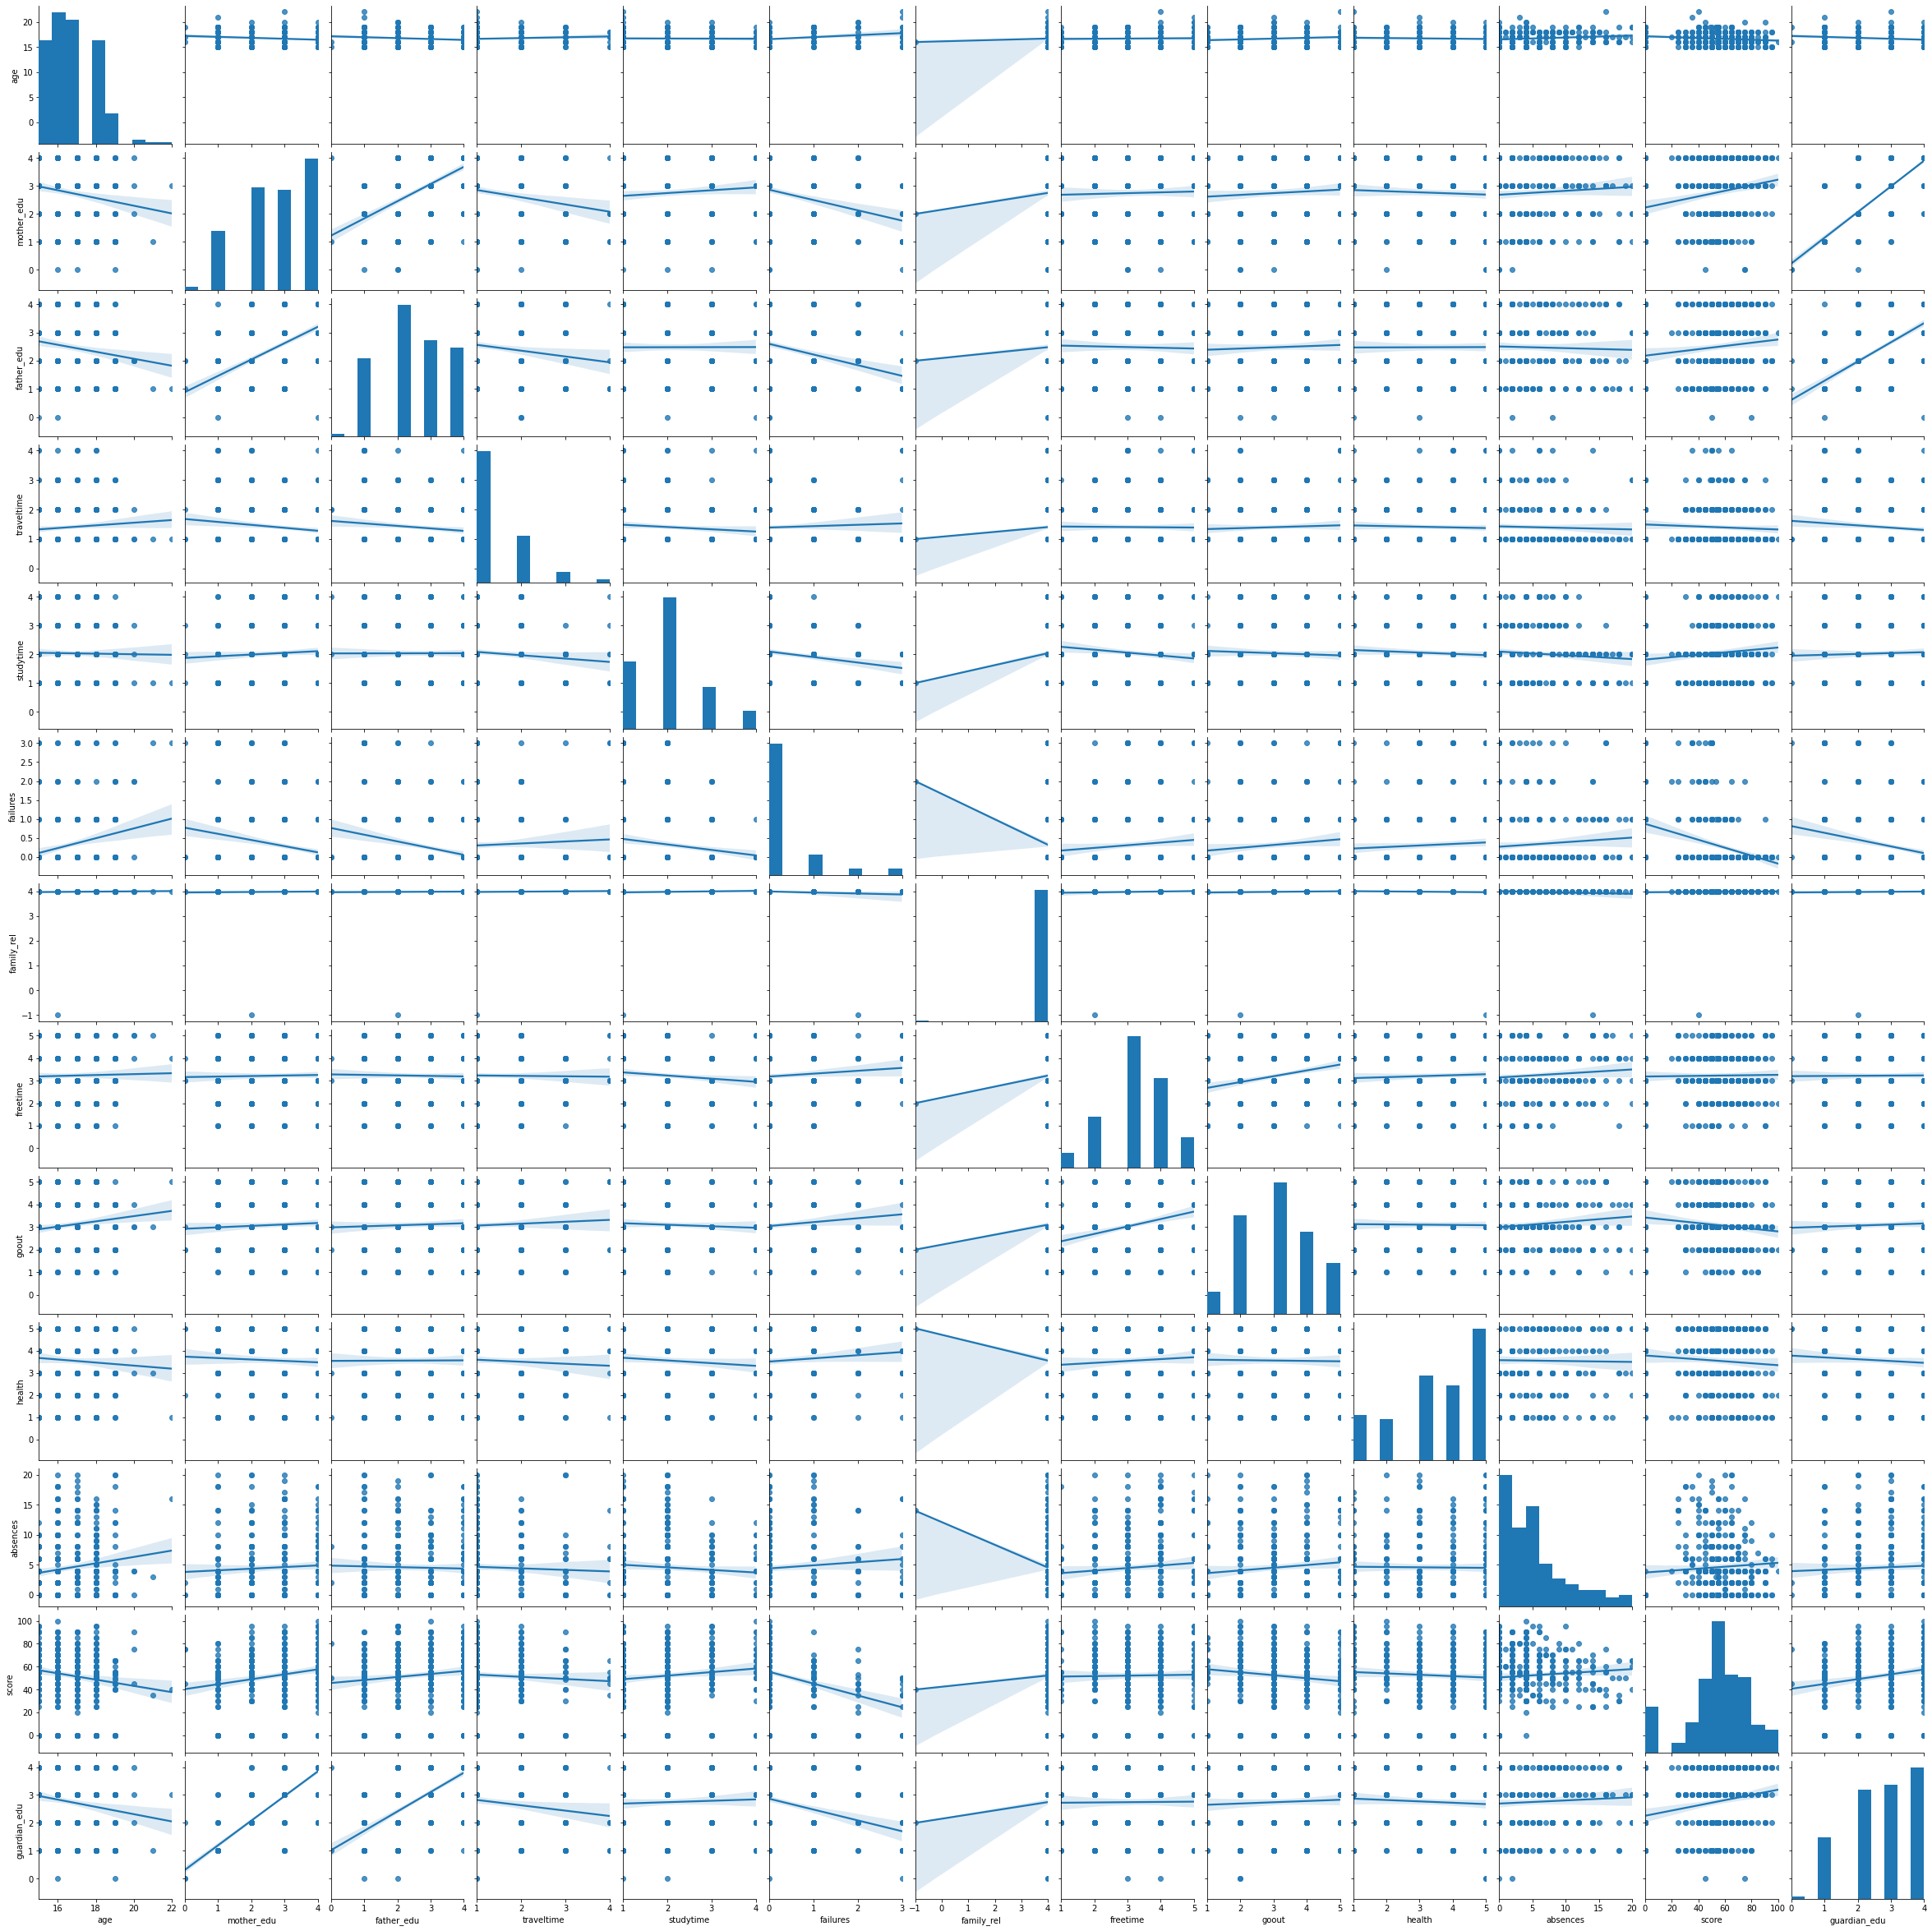

In [67]:
sns.pairplot(stud_data, kind = 'reg')

In [68]:
correlation = stud_data.corr()

correlation

,age,mother_edu,father_edu,traveltime,studytime,failures,family_rel,freetime,goout,health,absences,score,guardian_edu
age,1.000000,-0.161375,-0.148776,0.084755,-0.015355,0.228081,0.027522,0.026443,0.134069,-0.063892,0.141065,-0.153510,-0.155544
mother_edu,-0.161375,1.000000,0.597789,-0.160877,0.077050,-0.245110,0.034664,0.026210,0.063361,-0.050991,0.062010,0.207627,0.901641
father_edu,-0.148776,0.597789,1.000000,-0.132151,0.002252,-0.259194,0.022893,-0.023954,0.043961,0.004573,-0.027194,0.122759,0.688303
traveltime,0.084755,-0.160877,-0.132151,1.000000,-0.094637,0.049670,0.030303,-0.012496,0.051775,-0.044842,-0.036046,-0.056806,-0.121766
studytime,-0.015355,0.077050,0.002252,-0.094637,1.000000,-0.166598,0.062737,-0.119014,-0.051090,-0.073674,-0.074658,0.114193,0.039319
failures,0.228081,-0.245110,-0.259194,0.049670,-0.166598,1.000000,-0.116759,0.094826,0.113649,0.075849,0.079299,-0.329460,-0.263823
family_rel,0.027522,0.034664,0.022893,0.030303,0.062737,-0.116759,1.000000,0.063025,0.050406,-0.053330,-0.099586,0.027198,0.035086
freetime,0.026443,0.026210,-0.023954,-0.012496,-0.119014,0.094826,0.063025,1.000000,0.292305,0.060557,0.086704,0.017246,0.009086
goout,0.134069,0.063361,0.043961,0.051775,-0.051090,0.113649,0.050406,0.292305,1.000000,-0.014274,0.103337,-0.126964,0.046129
health,-0.063892,-0.050991,0.004573,-0.044842,-0.073674,0.075849,-0.053330,0.060557,-0.014274,1.000000,-0.013697,-0.072392,-0.063117


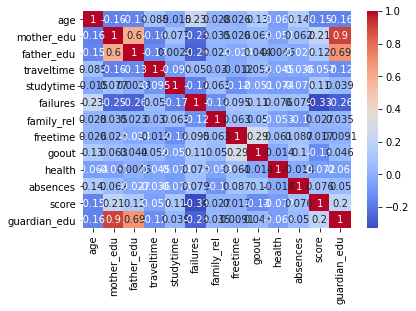

In [69]:
sns.heatmap(correlation, annot=True, cmap='coolwarm')

## Анализ номинативных переменных

In [70]:
nominal_column_list = [
    'school', 'sex',
    'address', 'family_size',
    'parent_status', 'mother_job',
    'father_job', 'reason',
    'guardian', 'schoolsup',
    'famsup', 'paid',
    'activities', 'nursery',
    'higher', 'internet',
    'romantic', 'guardian_job'
]

for col in nominal_column_list:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки mother_job
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки guardian_job


## Выводы

### Качество данных

Качество данных удовлетворительное, данные по столбцам все в едином формате, дубликаты данных отсутствуют, количество пропусков низкое в основном не более 10% (только у одного столбца 11% пропусков). Встретился один непонятный столбец "studytime, granular", но он полностью кореллировал со столбцом "studytime", поэтому по нему расчетов не проводил.

### Выводы, что влияет на балл по математике

Наиболее сильно влияет параметр 'failures' - количество внеучебных неудач
Также оказывает влияние образование родителей и производное поле образование опекуна (для удобство можно взять только образование опекуна, этот стоблец сильно кореллирует с образованием родителей)
Также оказывает влияние 'studytime' (время на учёбу помимо школы в неделю) и goout (проведение времени с друзьями)

Из номинативных признаков это: 'address' (локация проживания, за городом или в черте города), 'mother_job', 'guardian_job' (место работы матери и опекуна), 'higher' (планируемое получение высшего образования) и 'romantic' (наличие романтических отношений)